# Repertoire size distributions within highly sampled species
This Notebook generates Fig. 4D.

In [1]:
using NBInclude
@nbinclude("CRISPRCasdb.ipynb")

using Statistics, PyPlot, Random
rc(:svg,fonttype=:none)

include("get_repertoires.jl");

## No. of sampled strains by species

In [2]:
speciesid2num_genbanks_cc = Dict{Int,Int}(s => length(speciesid2genbanks_cc[s]) for s in keys(speciesid2genbanks_cc));

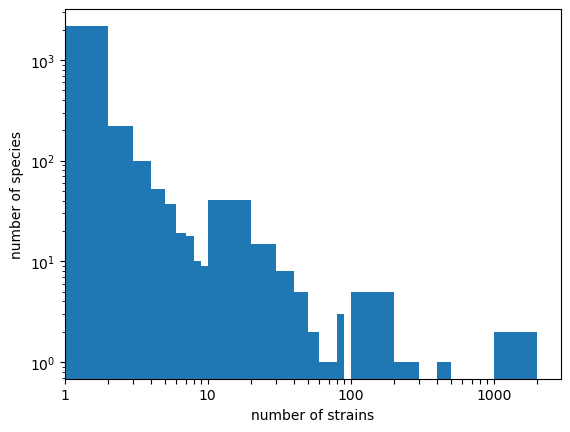

In [3]:
hist(log10.(values(speciesid2num_genbanks_cc)), bins=log10.(vcat(1:10,20:10:100,200:100:1000,2000)))

xlabel("number of strains")
ylabel("number of species")

xticks(log10.(vcat(collect(1:10),collect(20:10:100),collect(200:100:1000),2000)),
    string.(vcat(["1"],fill("",8),["10"],fill("",8),["100"],fill("",8),["1000",""])))

yscale(:log)

xmin, xmax = xlim()
xlim(0,xmax);

### repertoire size, mean spacer length, spacer lengths, and cas subtype of strains in each species

In [4]:
speciesids = collect(keys(speciesid2genbanks_cc)) # all species ids
p = sortperm([speciesid2num_genbanks_cc[s] for s in speciesids], rev=true) # sort by decreasing numboer of samples
speciesids = speciesids[p];

In [5]:
speciesid2repsizes_cc = Dict{Int,Array{Int}}()
# speciesid2spacerlens_cc = Dict{Int,Array{Array{Int}}}()

for s in speciesids
    num_gbs, repsizes, spacerlens = get_repertoires(speciesid2genbanks_cc[s], verbose=0)
    
    speciesid2repsizes_cc[s] = repsizes
#     speciesid2spacerlens_cc[s] = spacerlens
end

In [6]:
speciesid2subtypes_cc = Dict{Int,Array{String}}(s => [genbank2subtype[g] for g in speciesid2genbanks_cc[s]] for s in keys(speciesid2genbanks_cc));

## Focus on the most highly sampled species
"_spec" refers to this subset of highly sampled species.

In [7]:
num_samples = 50 # threshold number of samples

speciesids_spec = Int[]
names0_spec = String[]
repsizes_spec = Array{Int}[]
subtypes_spec = Array{String}[]

for s in speciesids
    if speciesid2num_genbanks_cc[s] >= num_samples
        push!(speciesids_spec,s)
        push!(names0_spec,taxid2name[s])
        push!(repsizes_spec,speciesid2repsizes_cc[s])
        push!(subtypes_spec,speciesid2subtypes_cc[s])
    end
end

names_spec = ["$(split(name)[1][1]). $(split(name)[2])" for name in names0_spec];

### count the number of samples with each given subtype

In [8]:
unique_subtypes_spec = sort.(unique.(subtypes_spec))
num_bysubtype_spec = Array{Int}[]

for i in 1:length(subtypes_spec)
    push!(num_bysubtype_spec, [count(x->x==st, subtypes_spec[i]) for st in unique_subtypes_spec[i]])
end

### get repertoire sizes of species + subtype combinations
"_spst" refers to species + subtype combinations.

In [9]:
spst2repsizes = Dict{Array{String},Array{Int}}()

for i in 1:length(names_spec)
    for j in 1:length(unique_subtypes_spec[i])
        if num_bysubtype_spec[i][j] >= 50 # threshold on >= 50 samples with species-subtype combination
            inds = findall(x->x==unique_subtypes_spec[i][j], speciesid2subtypes_cc[speciesids_spec[i]])
            spst2repsizes[[names_spec[i],unique_subtypes_spec[i][j]]] = repsizes_spec[i][inds]
        end
    end
end

In [10]:
for spst in keys(spst2repsizes)
    println(spst[1],"\t",spst[2],"\t",round(mean(spst2repsizes[spst]),sigdigits=2),"\t",round(std(spst2repsizes[spst]),sigdigits=2),"\t",round(std(spst2repsizes[spst])/mean(spst2repsizes[spst]),sigdigits=2))
end

E. coli	CAS-TypeIE	19.0	10.0	0.54
S. thermophilus	M	46.0	18.0	0.38
X. oryzae	CAS-TypeIC	76.0	18.0	0.24
A. baumannii	CAS-TypeIF	78.0	41.0	0.53
M. tuberculosis	CAS-TypeIIIA	31.0	13.0	0.42
S. agalactiae	CAS-TypeIIA	12.0	7.4	0.61
P. multocida	CAS-TypeIF	44.0	26.0	0.58
Y. pestis	CAS-TypeIF	12.0	3.9	0.31
K. pneumoniae	CAS-TypeIE	32.0	14.0	0.44
M. haemolytica	CAS-TypeIC	12.0	4.8	0.39
P. aeruginosa	CAS-TypeIF	42.0	12.0	0.28
C. difficile	CAS-TypeIB	98.0	31.0	0.31
S. enterica	CAS-TypeIE	34.0	21.0	0.62
C. jejuni	CAS-TypeIIC	4.3	3.4	0.8
S. pyogenes	M	6.8	3.9	0.58
E. coli	CAS-TypeIF	16.0	7.4	0.46
L. monocytogenes	CAS-TypeIIA	34.0	7.7	0.23


## Fig. 4C: Spacer repertoire size distributions

In [11]:
colors_s = vcat([[get_cmap("Blues",8)(i) for i in 1:7],
                 [get_cmap("Greens",3)(i) for i in 1:2]]...);

In [12]:
# choose 4 pairs of species-subtype combinations

stvec = ["CAS-TypeIE","CAS-TypeIF","CAS-TypeIC","CAS-TypeIIA"]
st2vec = ["I-E","I-F","I-C","II-A"]
cvec = [colors_s[5],colors_s[6],colors_s[3],colors_s[8]]

namevec = ["E. coli", "S. enterica", "E. coli", "P. aeruginosa", "M. haemolytica", "X. oryzae", "S. agalactiae", "L. monocytogenes"];

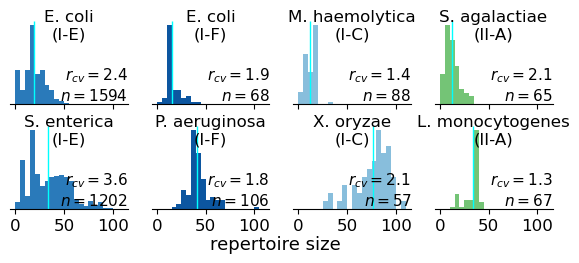

PyObject Text(0.41, -0.05, 'repertoire size')

In [13]:
ni = 2
nj = 4

fig, axs = subplots(ni, nj, figsize=(7, 2.5), sharex=true, sharey=false)

fs = 13

for j in 1:nj, i in 1:ni
    k = (j-1)*ni + i # index in spec_toplot
    spst = [namevec[k],stvec[j]]
    
    axs[i,j].hist(spst2repsizes[spst], bins=0:5:110, color=cvec[j]) # bins of width 5
    
    # plot mean
    ymin, ymax = axs[i,j].get_ylim()
    axs[i,j].vlines(mean(spst2repsizes[spst]), 0, ymax, color="cyan", linewidth=1)
    
    n = length(spst2repsizes[spst])
#     cv = round(std(spst2repsizes[spst])/mean(spst2repsizes[spst]),sigdigits=2)
    r_cv = round(std(spst2repsizes[spst])/sqrt(mean(spst2repsizes[spst])),sigdigits=2)
    
    axs[i,j].set_title("$(namevec[k])\n($(st2vec[j]))", fontsize=fs-1, loc="center", y=0.65)
#     axs[i,j].set_title("\$c_v=$cv\$\n\$n=$n\$", fontsize=fs-2, loc="right", y=-0.05)
    axs[i,j].set_title("\$r_{cv}=$r_cv\$\n\$n=$n\$", fontsize=fs-2, loc="right", y=-0.05)
    axs[i,j].set_xticks(0:50:100)
    axs[i,j].set_xticklabels(0:50:100, fontsize=fs-1)
    axs[i,j].set_yticks([])
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
    axs[i,j].spines["left"].set_visible(false)
end

fig.text(0.41,-0.05,"repertoire size", fontsize=fs)
# fig.text(0.095,0.19,"number of samples", fontsize=fs, rotation="vertical")

# savefig("repsizes_spec_subtype.svg",format="svg")

### permutation test

In [14]:
repsizes1 = spst2repsizes[[namevec[7],stvec[4]]]
mean1 = mean(repsizes1)
repsizes2 = spst2repsizes[[namevec[8],stvec[4]]]
mean2 = mean(repsizes2)

mean2-mean1

22.087256027554535

In [15]:
num = 10^6

diffs = Float64[]

for i in 1:num
    repsizes_shuf = shuffle(vcat(repsizes1,repsizes2))
    r1 = repsizes_shuf[1:length(repsizes1)]
    r2 = repsizes_shuf[length(repsizes1)+1:end]
    
    m1 = mean(r1)
    m2 = mean(r2)
    
    push!(diffs,m2-m1)
end

In [16]:
count(x->x>mean2-mean1, diffs)/num

0.0